# Distances in representation space

This notebook reproduces figures 3, 4, 5, and 8 in the "What is a meaningful representation of protein sequences paper". All these experiments were done on the PFAM00144 alignment file, in contrast to figures 6 and 7, which were based on an alignment of the class A beta-lactamases. The latter can be found in the blat_class_A1A2_experiments.ipynb.

In [1]:
import os
import re
import numpy as np

%load_ext autoreload
%autoreload 2

try:
  import pytorch_lightning as pl
except: 
  !pip install pytorch-lightning==1.2.10
  import pytorch_lightning as pl

try:
  import torchplot
except: 
  !pip install torchplot
  import torchplot
    
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Download repo if notebook is taken out of context (e.g. by colab)
if not os.path.exists('models'):
    !git clone https://github.com/MachineLearningLifeScience/What-is-a-meaningful-representation-of-protein-sequences tmp_clone
    !mv tmp_clone/* .
    !rm -rf tmp_clone

if not os.path.exists('PF00144_full_labeled.fasta'):
    !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta

## Load data

In [2]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F


from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1, numeric_curve_optimizer

def get_data(data_filename, calc_weights=True, similarity_threshold=0.8):
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        labels.append(label_re.search(record.description).group(1))
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)

    weights = None
    if calc_weights is not False:

        if not isinstance(similarity_threshold, list):
            similarity_threshold = [similarity_threshold]
        
        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = {}
        for st in similarity_threshold:
            weights[str(st)] = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            for st in similarity_threshold:
                w = 1.0 / (similarities / lengths).gt(st).sum(1).float()
                weights[str(st)].append(w)
            # plt.hist(similarities/lengths)
            
        for st in similarity_threshold:
            weights[str(st)] = torch.cat(weights[str(st)])
            #neff = weights.sum()

    return ids, seqs, labels, weights

# Note that we deviate from the normal choice of 0.8 for the similarity threshold. This is 
# Due to the PFAM alignment being extremely long, with lots of positions matching gaps.
ids, data, labels, weights = get_data("PF00144_full_labeled.fasta", calc_weights=True, 
                                      similarity_threshold=[0.01, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8])
print(weights)

#import matplotlib.pyplot as plt
#plt.hist(weights, bins=100)

{'0.01': tensor([3.5221e-05, 3.5220e-05, 3.5220e-05,  ..., 3.5221e-05, 3.5224e-05,
        3.5221e-05], device='cuda:0'), '0.05': tensor([3.5544e-05, 3.5433e-05, 3.5387e-05,  ..., 3.5663e-05, 3.5652e-05,
        3.5523e-05], device='cuda:0'), '0.1': tensor([3.6414e-05, 3.6181e-05, 3.6139e-05,  ..., 3.6709e-05, 3.6724e-05,
        3.6677e-05], device='cuda:0'), '0.15': tensor([4.4946e-05, 3.8719e-05, 3.8289e-05,  ..., 5.7544e-05, 5.7921e-05,
        4.7868e-05], device='cuda:0'), '0.2': tensor([1.6821e-04, 6.6116e-05, 6.5488e-05,  ..., 2.5806e-04, 5.7143e-04,
        1.5550e-04], device='cuda:0'), '0.4': tensor([0.1111, 0.0019, 0.0018,  ..., 0.5000, 0.1111, 0.5000], device='cuda:0'), '0.6': tensor([1.0000, 0.0500, 0.0333,  ..., 1.0000, 1.0000, 0.5000], device='cuda:0'), '0.8': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')}


## Embedding plotting code

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import os
from pathlib import Path

def plot_embeddings(model, labels, ax=None, name=None, current_epoch=None, save_to_file=False, 
                    xlim=None, ylim=None, legend=False, dimensionality_reduction=None, tsne_perplexity=30.,
                    precomputed_embeddings=None):
    
    phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
             'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
             'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)
    
    if not precomputed_embeddings:
        indices = torch.arange(len(labels))
        idx_mapper = []
        embeddings = []
        for batch,idx in model.train_dataloader(labels=indices, reweighting=False):
            batch = batch.long().to(model._device)
            zs = model.embedding(batch)
            embeddings.append(zs.detach().cpu())
            idx_mapper.append(idx)    

        embeddings = np.vstack(embeddings)
        idx_mapper = np.concatenate(idx_mapper)
        embedded_labels = torch.from_numpy(phyla_idx)[idx_mapper]
    else:
        embeddings, idx_mapper = precomputed_embeddings
        embedded_labels = (torch.from_numpy(phyla_idx)[idx_mapper]).squeeze()
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    plt.subplots_adjust(left=0.15, bottom=0.15, right=None, top=None, wspace=None, hspace=None)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if current_epoch is not None:
        plt.title('Epoch {:04d}'.format(current_epoch))
    
    # Color coding of organisms
    colors = [[106,61,154],
              [254,192,113],
              [226,28,29],
              [250,155,153],
              [252,129,2],
              [168,206,227],
              [51,162,45],
              [179,225,139],
              [28,121,179],
              [193,193,193]]
    
    colors = np.array(colors) / 255.0
    
    if dimensionality_reduction is None or embeddings.shape[1]==2:
        reduced_embeddings = embeddings
    elif dimensionality_reduction == "pca":
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca.fit(embeddings)
        reduced_embeddings = pca.transform(embeddings)
        if name is not None:
            name += "_pca"
    elif dimensionality_reduction == "tsne":
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
        reduced_embeddings = tsne.fit_transform(embeddings)
        if name is not None:
            name += "_tsne"
    elif dimensionality_reduction == "isomap":
        from sklearn.manifold import Isomap
        isomap = Isomap(n_components=2)
        reduced_embeddings = isomap.fit_transform(embeddings)
        if name is not None:
            name += "_isomap"
        
    if save_to_file:
        assert name is not None
        output_dir = name+"_z_plots"
        Path(output_dir).mkdir(exist_ok=True)
    
    for i in range(len(phyla))[::-1]:
        try:
            phyla_index = list(phyla_lookup_table).index(phyla[i])
        except:
            continue
            
        assert reduced_embeddings.shape[1] == 2
        
        ax.plot(reduced_embeddings[embedded_labels==phyla_index,0],
                reduced_embeddings[embedded_labels==phyla_index,1],
                '.', color=colors[i], label=phyla[i], markersize=1) 
        if legend:
            ax.legend()

    if save_to_file:
        plt.savefig(Path(output_dir, "epoch_{:04d}.png".format(current_epoch)))
        plt.close(fig)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(1)

    return embeddings, idx_mapper

## Train/retrieve VAE models

In [4]:
import time
def train_or_retrieve_model(name, data, weights, train_model, uncertainty_temperature, epochs=20, zdim=2, train_fraction=1.0,
                            kl_warmup_steps=1, aa_weights=None, seed=123, learning_rate=1e-3, batch_size=16, 
                            iwae_bound=False, mask_out_gaps=False, sparsity_prior=False, sparsity_prior_lambda=1e-4,
                            plot_dimensionality_reductions=[None], plot_xlim=[-10,10], plot_ylim=[-10,10], simplify_to_ae=False):
    
    cmd_args = ['-gpu', '1' if torch.cuda.is_available() else '0', 
                '-kl_warmup_steps', str(kl_warmup_steps), 
                "-epochs", str(epochs), 
                "-zdim", str(zdim),
                "-train_fraction", str(train_fraction), 
                "-seed", str(seed), 
                "-bs", str(batch_size),
                "-lr", str(learning_rate),
                "-iwae_bound", str(iwae_bound),
                "-mask_out_gaps", str(mask_out_gaps),                
                "-sparsity_prior", str(sparsity_prior),
                "-sparsity_prior_lambda", str(sparsity_prior_lambda),
                "-simplify_to_ae", str(simplify_to_ae)]
    if not train_model:
        cmd_args += ['-load_from', name+'.ckpt']
    hparams = get_hparams(cmd_args)

    pl.seed_everything(hparams.seed)

    perm = np.random.permutation(data.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget --no-check-certificate $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=data, perm=perm, weights=weights)

        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        
        # Trigger retraining of distnet, since this does not seem to be saved properly in checkpoint
        model.distnet.initialized = False

        # Number of points used for kmeans estimation for entropy network
        model.distnet.num_points = 1000
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])
        
    else:
        print('Training model!')
        model = VAE(data=data, weights=weights, perm=perm, hparams=hparams)
        
        class PlotCallback(pl.callbacks.Callback):
            def on_epoch_end(self, trainer, pl_module):
                for dimensionality_reduction in plot_dimensionality_reductions:
                    plot_embeddings(pl_module, labels, name=name, 
                                    current_epoch=trainer.current_epoch, save_to_file=True,
                                    xlim=plot_xlim, ylim=plot_ylim,
                                    dimensionality_reduction=dimensionality_reduction)
                
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs,
                             callbacks=[PlotCallback()])
        trainer.fit(model)
 
        # Trigger retraining of distnet
        model.distnet.initialized = False
        model.switch = True
        model.distnet.num_points = 1000

        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])

        trainer.save_checkpoint(name+'_{}.ckpt'.format(time.strftime("%Y%m%d")))

    return name,model

In [5]:
# Options
train_models = False

models = []
# models.append(train_or_retrieve_model('model_PF00144_reweighted_0.05', 
#                                       data,
#                                       weights=weights['0.05'],
#                                       train_model=train_models,
#                                       uncertainty_temperature=-3.5,
#                                       mask_out_gaps=True))
# models.append(train_or_retrieve_model('model_PF00144_reweighted_0.1', 
#                                       data,
#                                       weights=weights['0.1'],
#                                       train_model=train_models,
#                                       uncertainty_temperature=-3.5,
#                                       mask_out_gaps=True))
# models.append(train_or_retrieve_model('model_PF00144_reweighted_0.15', 
#                                       data,
#                                       weights=weights['0.15'],
#                                       train_model=train_models,
#                                       uncertainty_temperature=-3.5,
#                                       mask_out_gaps=True))
models.append(train_or_retrieve_model('model_PF00144_reweighted_0.2', 
                                      data,
                                      weights=weights['0.2'],
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
models.append(train_or_retrieve_model('model_PF00144_reweighted_0.4', 
                                      data,
                                      weights=weights['0.4'],
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
models.append(train_or_retrieve_model('model_PF00144_reweighted_0.6', 
                                      data,
                                      weights=weights['0.6'],
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
models.append(train_or_retrieve_model('model_PF00144_reweighted_0.8', 
                                      data,
                                      weights=weights['0.8'],
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
models.append(train_or_retrieve_model('model_PF00144', 
                                      data,
                                      weights=None,
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
# model_blat_ecolx = train_or_retrieve_model('model_BLAT_new8_20211006', 
#                                            data,
#                                            weights=None, #weights,
#                                            train_model=False,
#                                            uncertainty_temperature=-4.5,
#                                            kl_warmup_steps=10000,
#                                            learning_rate=1e-4,
#                                            epochs=40,
#                                            train_fraction=1.0,
#                                            aa_weights=None, #aa_weights,
#                                            seed=123,
#                                            batch_size=16,
#                                            iwae_bound=False,
#                                            sparsity_prior=True,
#                                            sparsity_prior_lambda=1e-3)


Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


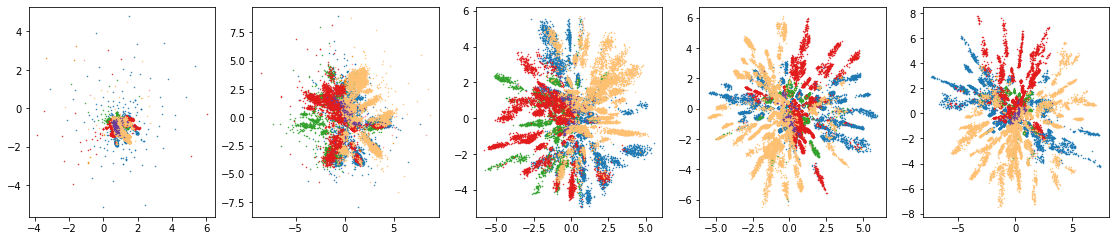

In [6]:
fig, ax = plt.subplots(1, len(models), figsize=(len(models)*4, 4))

embeddings = {}
idx_mappers = {}
for idx,(name, model) in enumerate(models):
    embedding, idx_mapper = plot_embeddings(model, labels, ax=ax[idx])
    embeddings[name] = embedding
    idx_mappers[name] = idx_mapper

## Entropy plot

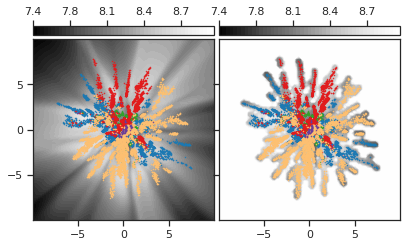

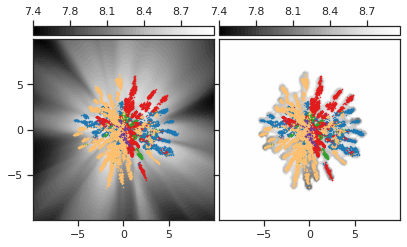

In [7]:
import torch.distributions as D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import seaborn as sns
custom_style = {'grid.color': '0.5'}
sns.set_theme(style="ticks")

n_points = 100
xy_min, xy_max = -10,10

z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(xy_min,xy_max,n_points)])]).t()

entropies = {}
vminmax = {}
for idx1, name in enumerate(["model_PF00144", "model_PF00144_reweighted_0.8"]):
    entropies[idx1] = {}
    model = dict(models)[name]
    for idx2, model_switch in enumerate([False, True]):
        model.switch=model_switch
        recon = model.decode(z_grid, as_probs=True)
        d = D.Categorical(probs=recon.permute(0,2,1))
        var1 = d.entropy().sum(dim=-1)
        entropies[idx1][idx2] = var1
    entropies_stacked = torch.stack(list(entropies[idx1].values())) 
    vminmax[idx1] = (entropies_stacked.min().log().item(), entropies_stacked.max().log().item())
        
# for idx1, (name, model) in enumerate(models):
for idx1, name in enumerate(["model_PF00144", "model_PF00144_reweighted_0.8"]):
    model = dict(models)[name]
    fig, ax = plt.subplots(1, 2, figsize=(2*3, 4.), sharey=True)
    
    plt.subplots_adjust(left=0, bottom=None, right=1.0, top=None, hspace=0.00, wspace=0.025)

    # Plot with and without entropy network enabled
    for idx2, model_switch in enumerate([False, True]):
        var1 = entropies[idx1][idx2]
        
        plot_embeddings(model, labels, ax=ax[idx2],
                       precomputed_embeddings=(embeddings[name], idx_mappers[name]))
        levels = torch.linspace(vminmax[idx1][0], vminmax[idx1][1], 50)
        c = ax[idx2].contourf(z_grid[:,0].reshape(n_points, n_points),
                      z_grid[:,1].reshape(n_points, n_points),
                      var1.log().reshape(n_points, n_points).detach(), levels=levels, cmap='Greys_r', zorder=0)
        ax[idx2].set_xlim([xy_min, xy_max])
        ax[idx2].set_ylim([xy_min, xy_max])

        ax[idx2].set_xticks([-5,0,5])
        ax[idx2].set_yticks([-5,0,5])
        ax[idx2].set_aspect('equal')

        divider = make_axes_locatable(ax[idx2])
        #cax = divider.append_axes('right' if model_switch else 'left', size='5%', pad=0.05)
        # cb = fig.colorbar(c, cax=cax, orientation='vertical', format="%.1f")
        cax = divider.append_axes('top', size='5%', pad=0.05)
        cb = fig.colorbar(c, cax=cax, orientation='horizontal', format="%.1f")
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.locator_params(nbins=5)
    plt.savefig('vae_entropy_{}.pdf'.format(idx1), bbox_inches='tight')


## Phylogenetic tree

In [8]:
# Options
run_preprocessing = False

def calculate_or_predict_tree(filename, run_processing):

    phylo_ids = []
    for record in SeqIO.parse(filename, "fasta"):
        phylo_ids.append(record.id.split('/')[0])

    output_filename = filename.replace(".fasta", "_tree.txt")
    output_filename_dist_matrix = filename.replace(".fasta", "_distance_matrix.txt")
    output_filename_dist_matrix_pickle = filename.replace(".fasta", "_distance_matrix.pbz2")
        
    if run_preprocessing:

        !FastTree &> /dev/null
        if _exit_code != 0:

            # Attempt at making script self-contained by installing FastTree via conda. 
            # Seems to work on colab, but might not be super robust
            !conda --version
            if _exit_code != 0:
                !pip install -q condacolab
                import condacolab
                condacolab.install()

            !conda install -y -c bioconda fasttree 

        # Estimate tree
        !FastTree < $filename > $output_filename
        !FastTree -makematrix $filename > $output_filename_dist_matrix

        df = pd.read_table(output_filename_dist_matrix, delimiter=' ', header=None, index_col=0, skiprows=1, engine='c')
        df.astype(np.float32).to_pickle(output_filename_dist_matrix_pickle, compression='bz2')
        
    else:
        # Retrieve Beta-lactamase tree file
        if not os.path.exists(output_filename):
            url = "https://sid.erda.dk/share_redirect/a5PTfl88w0/" + output_filename
            !wget --no-check-certificate $url
            
        if not os.path.exists(output_filename_dist_matrix_pickle):
            url = "https://sid.erda.dk/share_redirect/a5PTfl88w0/" + output_filename_dist_matrix_pickle
            !wget --no-check-certificate $url
                
calculate_or_predict_tree("PF00144_full_labeled.fasta", run_preprocessing)

In [9]:
try:
    from Bio import Phylo
except:
    !pip install biopython
    from Bio import Phylo

class TreeDist(object):
    def __init__(self, filename):
        self.tree = next(Phylo.parse(filename, 'newick'))
        self.leaves = list(self.tree.get_terminals())
        
        self.leaf_lookup = {}
        for i, leaf in enumerate(self.leaves):
            self.leaf_lookup[leaf.name] = i

    def id_to_id_dist(self, id1, id2):

        idx1 = self.leaf_lookup[id1]
        idx2 = self.leaf_lookup[id2]

        return self.tree.distance(self.leaves[idx1],
                                  self.leaves[idx2])
    
td = TreeDist("PF00144_tree.txt")
# td = TreeDist("BLAT_ECOLX_1_b0.5_labeled_tree.txt")

print("Leaves: ", len(td.leaves))

Leaves:  36328


In [10]:
import scipy.stats
import pandas as pd

def initializing_curve_length(model, curve):
    # Function passed to FastDiscreteManifold for initialization
    # Use entropy network output s as a proxy for the entropy along the curve
    _, s = model.decode(curve, return_s=True)
    weight = s.squeeze().mean(dim=-1)
    return weight

def create_discretized_manifold(model, n_points=100, grid_min=-8, grid_max=8, sample_around_grid_points = False):
    
    # Create grid and calculate discretized version of manifold, so that geodesics can be calculated using
    # graph algorithm
    z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(grid_min, grid_max,n_points)])]).t()

    if sample_around_grid_points:
        # Sample around grid points, allowing grid points to move off the original grid towards area of lower entropy
        n_samples = 10
        resolution = (grid_max-grid_min)/n_points
        z_grid_sampled = torch.distributions.Normal(loc=z_grid, scale=z_grid*0+resolution/2).sample([n_samples])
        decoded = D.Categorical(probs=model.decode(z_grid_sampled, as_probs=True).permute(0,1,3,2))
        z_grid = z_grid_sampled[decoded.entropy().sum(dim=-1).argmin(dim=0), 
                                torch.arange(0, z_grid_sampled.shape[1])]

    from models.geoml.manifold import EmbeddedManifold, CubicSpline
    from models.geoml.discretized_manifold import FastDiscretizedManifold
    return FastDiscretizedManifold(model, z_grid.t().reshape(2,n_points,n_points), 
                                   use_diagonals=True, batch_size=256,
                                   external_curve_length_function=initializing_curve_length)    
dms = {}
for i, (name,model) in enumerate(models):
    print('\n', name, ': Creating discretized manifold')
    dms[name] = create_discretized_manifold(model)


 model_PF00144_reweighted_0.2 : Creating discretized manifold

 model_PF00144_reweighted_0.4 : Creating discretized manifold

 model_PF00144_reweighted_0.6 : Creating discretized manifold

 model_PF00144_reweighted_0.8 : Creating discretized manifold

 model_PF00144 : Creating discretized manifold


In [11]:
# Load embeddings for transformed trained on beta-lactamase
import pickle
if not os.path.exists('transformer_new.pkl'):
    !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/transformer_new.pkl
        
with open('transformer_new.pkl', 'rb') as f:
    transformer_embeddings = pickle.load(f)
transformer_embeddings[0].shape
transformer_embeddings_df = pd.DataFrame(transformer_embeddings[0], index=transformer_embeddings[1])
transformer_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
A0A010RE24_PSEFL,0.944720,2.844626,-2.366162,0.350335,-0.414443,-4.822055,0.375892,-8.645848,0.116789,1.395336,...,9.974604,0.162389,-3.039766,2.979874,-0.459378,0.969932,3.126505,0.528213,-1.487851,4.432051
A0A010SU85_PSEFL,1.209345,1.958406,-2.541552,-0.765289,-1.346410,-5.540593,-1.273250,-6.736852,1.419525,-0.898686,...,9.915537,-2.371793,-3.318264,2.052666,0.074075,0.695836,6.270581,3.248281,-2.653239,4.081680
A0A010SUD7_PSEFL,2.481022,-1.647726,1.066896,0.562195,-2.097845,-3.357439,-1.490241,0.138865,-0.121766,1.823745,...,6.334902,0.868887,1.901826,1.050600,-1.593089,1.283691,0.382361,-0.117892,-0.352753,-0.933384
A0A010SUV2_PSEFL,1.484547,-1.346554,-2.256628,-1.059989,-1.704411,-1.781917,0.080790,-0.079057,1.135832,-0.445503,...,2.413050,0.649929,-1.468426,0.139696,-0.582900,0.953191,0.851948,0.346148,-1.952076,-1.376005
A0A010YR49_9ACTN,-2.558004,-2.192567,-3.865906,-0.943369,-1.530529,2.601545,2.659317,4.253436,-1.130634,0.085900,...,-2.900348,0.842569,-0.309693,-0.931333,-1.739355,3.644900,-1.316426,-3.104918,-3.644159,-0.639200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z9JPJ5_9MICO,-1.686200,-1.741917,-4.572061,0.381095,-0.999108,0.821874,1.389840,1.157189,0.382510,-1.770751,...,-0.157507,1.064967,-0.441762,-2.383981,0.559202,1.912716,0.871577,0.521168,-3.027293,0.936037
Z9JQ99_9MICO,-1.930591,-0.569509,0.191149,-2.449956,-2.111974,1.436355,0.112413,2.938181,-1.476185,-0.630180,...,-2.000967,-7.869652,-3.536053,1.104713,-1.295780,2.239443,4.184923,-1.497656,-3.027870,1.894033
Z9JQD4_9MICO,-0.382678,-0.951435,-2.600303,-0.794238,-1.123209,0.971773,0.583222,-1.517119,0.538810,-3.127371,...,-1.726384,-6.049063,-5.636968,-1.511359,2.143791,-0.102461,4.229878,1.270319,-2.061830,2.138013
Z9JQP7_9MICO,-0.363310,-0.352909,-1.603731,-1.577192,-1.573427,3.824772,4.350486,-3.053071,-2.648892,1.151268,...,-5.440436,-8.056438,-10.948663,1.671524,0.358158,1.060098,0.220123,-6.438080,-1.516309,1.930846


In [12]:
from scipy import interpolate
from scipy.special import softmax
from models.geoml.curve import BasicCurve

np.random.seed(42)

class SplineApprox(BasicCurve):
    def __init__(self, discreate_curve):
        self.device = discreate_curve.device
        out = discreate_curve(torch.linspace(0,1,100)).detach()
        x, y = out.T
        self.f, _ = interpolate.splprep([tuple(xi for xi in x), tuple(yi for yi in y)], k=5)

    def __call__(self, t):
        xint, yint = interpolate.splev(t, self.f)
        return torch.stack([torch.tensor(xint), torch.tensor(yint)]).T.float()
    
n_samples = 500
n_repetitions = 5

sample_idx_rep = []
for idx in range(n_repetitions):

    # To get a more balanced set, we upweight sequences by their distance to to center
    model = dict(models)["model_PF00144_reweighted_0.8"]
    reverse_idx_mapper = np.argsort(model.perm)
    data_weights = (softmax(np.linalg.norm(embeddings["model_PF00144_reweighted_0.8"], ord=2, axis=-1)))[reverse_idx_mapper]
    
    sample_idx_i = np.random.choice(len(model.train_dataloader().dataset), size=2*n_samples, replace=False, p=data_weights)
    sample_idx_j = np.random.choice(len(model.train_dataloader().dataset), size=2*n_samples, replace=False, p=data_weights)

    # # Alternative - Reweight samples to obtain uniform distribution over distances using distance matrix from FastTree
    # df_distance_matrix = pd.read_pickle('PF00144_full_labeled_distance_matrix.pbz2', compression='bz2')
    # df_distance_matrix_1d = df_distance_matrix.values.ravel()
    # 
    # bins = 20
    # 
    # plt.hist(df_distance_matrix_1d, bins=bins)
    # 
    # mean = np.mean(df_distance_matrix_1d)
    # std = np.std(df_distance_matrix_1d)
    # bin_array = np.linspace(mean-3*std, mean+3*std, bins)
    # 
    # counts, edges = np.histogram(df_distance_matrix_1d, bins=bin_array)
    # digitized = np.fmin(np.digitize(df_distance_matrix_1d, edges), bins)
    # 
    # weight_per_datapoint = np.zeros(bins+1)
    # weight_per_datapoint[1:-1] = (1./(bins+1)*1./counts)
    # distance_weights = weight_per_datapoint[digitized]
    # 
    # # Renormalize weights to make np.choice happy
    # distance_weights /= np.sum(distance_weights)

    
    # Some models are only trained on part of the entire dataset. Therefore, we attempt the lookup, and ignore
    # Failures. We start off with twice as many samples then necessary, and truncate in the end    
    sample_idx_filtered = {(i,j):True for i,j in zip(sample_idx_i, sample_idx_j)}
    for model_name, model in models:
        for i,j in list(sample_idx_filtered.keys()):
            # reverse_idx_mapper = np.argsort(idx_mappers[model_name])
            reverse_idx_mapper = np.argsort(model.perm)
            idx_i, idx_j = reverse_idx_mapper[i], reverse_idx_mapper[j]
            if idx_i >= len(embeddings[model_name]) or idx_j >= len(embeddings[model_name]) or not ids[i].split('/')[0] in transformer_embeddings_df.index or not ids[j].split('/')[0] in transformer_embeddings_df.index:
                del sample_idx_filtered[(i,j)]
                continue
                
    sample_idx = list(sample_idx_filtered.keys())[:n_samples]
    sample_idx_rep.append(sample_idx)
    print(len(sample_idx))

distances = {}
for idx in range(n_repetitions):
    
    sample_idx = sample_idx_rep[idx]
        
    for model_name, model in models:
        
        print(model_name)

        if model_name not in distances:
            distances[model_name] = []
        
        reverse_idx_mapper = np.argsort(model.perm)

        print('\t Calculating phylogenetic distances')
        # embedded_ids = np.array(ids)[idx_mappers[model_name]]    
        phylo_distances = []
        for i, j in sample_idx:
#             phylo_distances.append(td.id_to_id_dist(embedded_ids[i], 
#                                                     embedded_ids[j]))
            phylo_distances.append(td.id_to_id_dist(ids[i], 
                                                    ids[j]))

        print('\t Calculating transformer distances')
        transformer_distances = []
        for i, j in sample_idx:
#        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = transformer_embeddings_df.loc[ids[i].split('/')[0]].to_numpy()
            em2 = transformer_embeddings_df.loc[ids[j].split('/')[0]].to_numpy()
            transformer_distances.append(np.linalg.norm(em1-em2))

        # Some models are only trained on part of the entire dataset. Therefore, we attempt the lookup, and ignore
        # Failures. We start off with twice as many samples then necessary, and truncate in the end
        model_idx = []
        for i,j in sample_idx:
            model_idx.append((reverse_idx_mapper[i], reverse_idx_mapper[j]))
        assert len(model_idx) == n_samples

        print('\t Calculating VAE distances')
        vae_distances = []
        for i, j in model_idx:
#        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embeddings[model_name][i]
            em2 = embeddings[model_name][j]
            vae_distances.append(np.linalg.norm(em1-em2))

        print('\t Calculating VAE geodesics')
        vae_geo_distances = []
        for i, j in model_idx:
#        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embeddings[model_name][i]
            em2 = embeddings[model_name][j]
            curve, dist = dms[model_name].shortest_path(em1, em2)

            if curve.num_nodes >2: 
                curve = numeric_curve_optimizer(model, curve)

                if i != j and dms[model_name].grid_point(em1) != dms[model_name].grid_point(em2):
                    curve = SplineApprox(curve)

                dist = float(model.curve_length(curve(torch.linspace(0, 1, 100))))
            else:
                dist = np.linalg.norm(em1-em2)

            vae_geo_distances.append(dist)

        print('\t Calculating Hamming distances')
        embedded_data = data[idx_mappers[model_name]]
        hamming_distances = []
        for i, j in sample_idx:
#            hamming_distances.append(scipy.spatial.distance.hamming(embedded_data[i], embedded_data[j]))
            hamming_distances.append(scipy.spatial.distance.hamming(data[i], data[j]))

        print('\t Calculating expected Hamming distances')
        exp_hamming_distances = []
        for i, j in model_idx:
#        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embeddings[model_name][i]
            em2 = embeddings[model_name][j]
            dec1 = torch.distributions.Categorical(model.decode(torch.tensor(em1).reshape(1,-1), as_probs=True).permute(0,2,1))
            dec2 = torch.distributions.Categorical(model.decode(torch.tensor(em2).reshape(1,-1), as_probs=True).permute(0,2,1))
            exp_hamming_distances.append(np.mean([scipy.spatial.distance.hamming(dec1.sample(), dec2.sample()) for _ in range(20)]))


        distances[model_name].append({'transformer':(transformer_distances, phylo_distances),
                                      'vae':(vae_distances, phylo_distances),
                                      'vae_geo':(vae_geo_distances, phylo_distances), 
                                      'hamming':(hamming_distances, phylo_distances),
                                      'exp hamming': (exp_hamming_distances, phylo_distances)})   

distances = pd.DataFrame(distances)
distances.to_json("distance_calculations.json")
distances_dict = distances.to_dict()


500
500
500
500
500
model_PF00144_reweighted_0.2
	 Calculating phylogenetic distances
	 Calculating transformer distances
	 Calculating VAE distances
	 Calculating VAE geodesics
	 Calculating Hamming distances
	 Calculating expected Hamming distances
model_PF00144_reweighted_0.4
	 Calculating phylogenetic distances
	 Calculating transformer distances
	 Calculating VAE distances
	 Calculating VAE geodesics
	 Calculating Hamming distances
	 Calculating expected Hamming distances
model_PF00144_reweighted_0.6
	 Calculating phylogenetic distances
	 Calculating transformer distances
	 Calculating VAE distances
	 Calculating VAE geodesics
	 Calculating Hamming distances
	 Calculating expected Hamming distances
model_PF00144_reweighted_0.8
	 Calculating phylogenetic distances
	 Calculating transformer distances
	 Calculating VAE distances
	 Calculating VAE geodesics
	 Calculating Hamming distances
	 Calculating expected Hamming distances
model_PF00144
	 Calculating phylogenetic distances
	 Cal

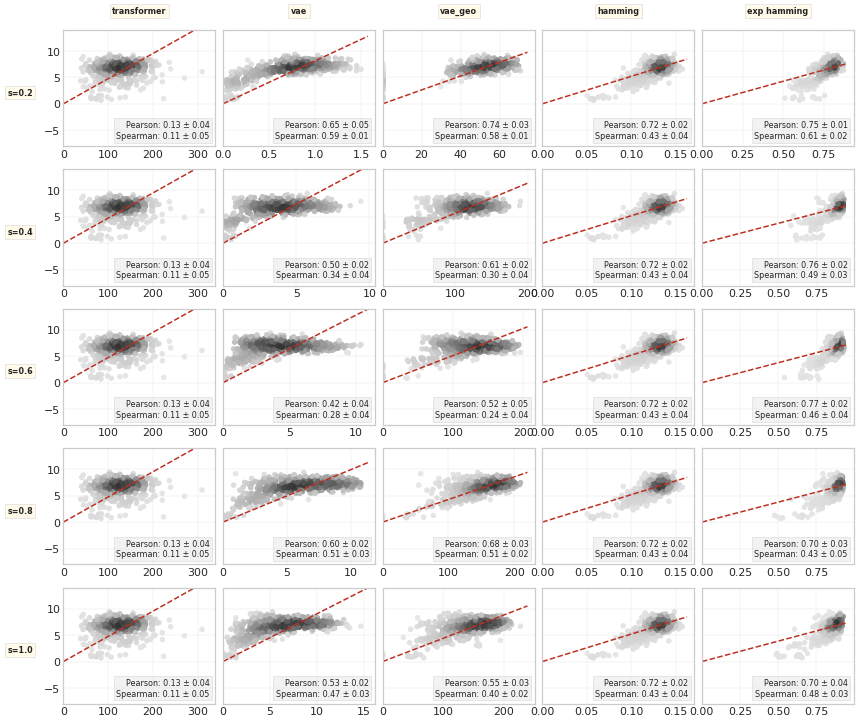

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
import scipy.stats
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

distances_df = pd.DataFrame.from_dict({(i,j): distances_dict[i][j] 
                           for i in distances_dict.keys() 
                           for j in distances_dict[i].keys()},
                       orient='index')

red = [.74, .18, .12]
yellow = "#fff6d5"
cmap = truncate_colormap(plt.get_cmap('gray_r'), 0.1, 0.80)

weighting_schemes = distances_df.index.get_level_values(0).unique()
model_types = distances_df.columns

sns.set_theme(style="whitegrid")
sns.set_context(rc={"grid.linewidth": 0.2})

fig, ax = plt.subplots(len(weighting_schemes), len(model_types), sharex=False, sharey=True, figsize=(12,12.))
plt.subplots_adjust(wspace=0.05, hspace=0.2, left=0.075, right=0.99, bottom=0.2, top=0.98)

def scatter_plot(datapoints, ax, title=None):

    spearmans = []
    pearsons = []
    for repetition in range(datapoints.shape[0]):

        x = datapoints[repetition,0]
        y = datapoints[repetition,1]

        spearmans.append(scipy.stats.spearmanr(x, y).correlation)
        pearsons.append(np.corrcoef(x,y)[0,1])

    corr_str = """Pearson: {:.2f} ± {:.2f}\nSpearman: {:.2f} ± {:.2f}""".format(np.mean(pearsons), 
                                                                                np.std(pearsons), 
                                                                                np.mean(spearmans), 
                                                                                np.std(spearmans))

    # Visualize first repetition
    x = datapoints[0,0]
    y = datapoints[0,1]

    xy = np.vstack([x,y])

    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z, cmap=cmap, s=20)

    line_x = np.linspace(0, ax.get_xlim()[1], 500)

    coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y, rcond=None)
    line_y = coeff_a*line_x
    
    r2 = r2_score(y,coeff_a*x)
    # corr_str = '''$R^2$: {:.2f}\n'''.format(r2) + corr_str
    
    #coef = np.polyfit(x,y,1)
    #line_y = np.poly1d(coef)(line_x)

    ax.plot(line_x, line_y, '--', color=red)

    ax.tick_params(axis='both', which='major', pad=-3)

    if title:
        props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.9, )
        ax.text(0.96, 0.95, title, transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')

    props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

    ax.text(0.96, 0.05, corr_str, transform=ax.transAxes, fontsize=8, verticalalignment='bottom', horizontalalignment='right', bbox=props)

    ax.set_xlim(left=0)
    

for idx1, weighting_scheme in enumerate(weighting_schemes):

    weight_label = "1.0"
    if "reweighted" in weighting_scheme:
        weight_label = re.search("reweighted_([0-9.]+)", weighting_scheme).group(1)
    props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )
    ax[idx1, 0 ].text(-0.2, 0.5, "s={}".format(weight_label), transform=ax[idx1, 0].transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')

    for idx2, model in enumerate(distances_df.columns):

        if idx1==0:
            props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )
            ax[0, idx2].text(0.5, 1.2, model, transform=ax[0, idx2].transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center', bbox=props, fontweight='bold')

        datapoints = np.array(distances_df.loc[weighting_scheme, model].to_list())
        if len(datapoints.shape)>2:
            scatter_plot(datapoints, ax[idx1, idx2])
            
        ax[idx1, idx2].set_ylim([-8,14])
            
        
plt.savefig("correlations_all.pdf", bbox_inches='tight')

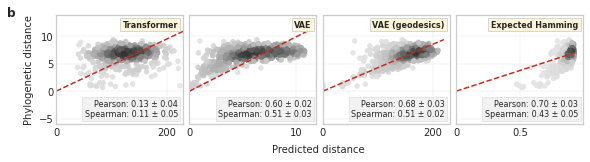

In [14]:
# Figure for paper

sns.set_theme(style="whitegrid")
sns.set_context(rc={"grid.linewidth": 0.2})

model_types = [("Transformer","transformer"), ("VAE", "vae"), ("VAE (geodesics)", "vae_geo"), ("Expected Hamming", "exp hamming")]
fig, ax = plt.subplots(1, len(model_types), sharex=False, sharey=True, figsize=(2*len(model_types),2.))
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.075, right=0.99, bottom=0.2, top=0.96)

for idx, (title, model_type) in enumerate(model_types):

    datapoints = np.array(distances_df.loc["model_PF00144_reweighted_0.8", model_type].to_list())
    if len(datapoints.shape)>2:
        scatter_plot(datapoints, ax[idx], title=title)
        
    ax[idx].set_ylim([-6, 14])
    ax[idx].tick_params(axis='x', labelsize=10)
    ax[idx].tick_params(axis='y', labelsize=10)

    ax[idx].locator_params(axis='y', nbins=4)
    ax[idx].locator_params(axis='x', nbins=2)
    from matplotlib.ticker import FormatStrFormatter, FuncFormatter
    ax[idx].xaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%d"%x if (x.is_integer()) else "%.1f"%x))
    
    if model_type == "transformer":
        ax[idx].set_xlim([0, 230])

ax[0].set_ylabel("Phylogenetic distance", fontsize=10)
plt.gcf().text(0.45, 0.00, "Predicted distance", fontsize=10)
plt.gcf().text(0.005, 0.925, "b", fontsize=12, weight='bold', 
           verticalalignment='bottom', horizontalalignment='right')

plt.savefig("correlation5.pdf", bbox_inches='tight')

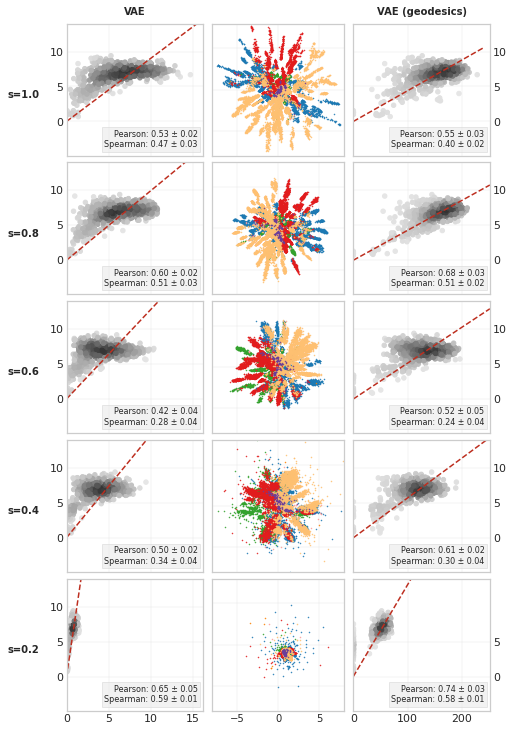

In [15]:
fig, ax = plt.subplots(len(models), 3, sharex='col', sharey=False, figsize=(7,11.5))
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.075, right=0.99, bottom=0.2, top=0.98)

for idx,(name, model) in enumerate(models[::-1]):
    
    weight_label = "1.0"
    if "reweighted" in name:
        weight_label = re.search("reweighted_([0-9.]+)", name).group(1)
    ax[idx, 0 ].text(-0.2, 0.5, "s={}".format(weight_label), transform=ax[idx, 0].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', fontweight='bold')    
    
    for j in range(3):
        if j==1:
            plot_embeddings(model, labels, ax=ax[idx,1],
                            precomputed_embeddings=(embeddings[name], idx_mappers[name]), xlim=[-8,8], ylim=[-8,8])
            ax[idx,1].set_aspect('equal')
            plt.yticks([-5,0,5])
            props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.9, )

            # title = name.replace("model_PF00144", "VAE").replace('_', ' ')
            # if 'reweighted' in title:
            #     title = title.replace('reweighted', '(reweighted') + ')'
            # ax[idx,1].text(0.96, 0.95, title, transform=ax[idx,1].transAxes, fontsize=8,
            #              verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')
            ax[idx,1].tick_params(axis='x', labelsize=10)
            ax[idx,1].tick_params(axis='y', labelsize=10)
            ax[idx,1].tick_params(axis='both', which='major', pad=-3)
            ax[idx,1].yaxis.set_ticklabels([])
        else:
            if j==0:
                key = "vae"
                title = "VAE"
            if j==2:
                key = "vae_geo"
                title = "VAE (geodesics)"
                ax[idx,j].tick_params(axis='y', which='both', labelleft=False, labelright=True)
                
                #ax[idx,2].set_yticks(ax[idx,0].get_yticks())
                #ax[idx,2].set_ylim(ax[idx,0].get_ylim())
            ax[idx,j].set_ylim(-4.9, 14)
            
            datapoints = np.array(distances_df.loc[name, key].to_list())
            scatter_plot(datapoints, ax[idx, j])

            if idx==0:
                props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )
                ax[0, j].text(0.5, 1.125, title, transform=ax[0, j].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center', fontweight='bold')

plt.savefig('vae_normal_vs_reweighted.png', dpi=600, bbox_inches='tight')            
            
            

## Ancestral reconstruction

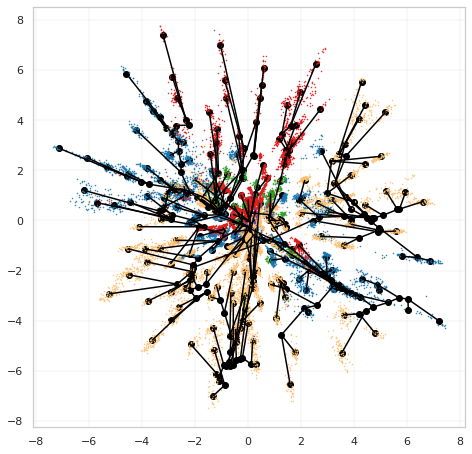

In [16]:
# Options
run_preprocessing = False

representative_point_labels = ['A0A1S9B261_9BACT', 'A0A1N6S5V9_9SPHI', 'A0A0G3XB70_9SPHN', 'A0A124H8F2_9ACTN', 'A0A0H0XMZ2_9SPHN', 'A0A1H3MS29_9MICO', 'A0A1C4RXZ6_9ACTN', 'K6YB53_9ALTE', 'D7BUJ0_STRBB', 'V4PEL1_9CAUL', 'A0A0R2T7U0_9GAMM', 'W6TRC3_9SPHI', 'A0A095V1K0_9FLAO', 'H5UKC9_9ACTN', 'A0A086GHA9_STRSC', 'I0K217_9BACT', 'A0A1E5SZ29_9BACT', 'A0A162YSP3_9FLAO', 'A0A1J4NQQ5_9ACTN', 'U5VSN6_9ACTN', 'A0A1C4SSD9_9ACTN', 'A0A1W9IDH3_9PROT', 'A0A142HQP5_9SPHI', 'A0A1S1R3M6_9ACTN', 'A0A1I1BJF2_9RHIZ', 'U5EQF0_NOCAS', 'A0A0X3XPR2_9ACTN', 'H6R079_NOCCG', 'A0A117P596_9ACTN', 'A0A1A1WA84_9MYCO', 'A0A0P1E0C4_9RHOB', 'A0A1A1W888_9MYCO', 'A0A1H7JGC4_9FLAO', 'A0A239H288_9ACTN', 'A0A1Q3TL54_9SPHI', 'K4KU84_SIMAS', 'A0A1I5UY06_9BURK', 'R1I1M6_9PSEU', 'Q1QJW4_NITHX', 'A0A132PRK9_9MYCO', 'A0A1U9RJ97_9PROT', 'A0A1M7RYP7_9SPHN', 'A0A1B2AFT2_9SPHN', 'A0A0A0M5Y1_9GAMM', 'A0A0F5VWV8_9ACTN', 'I2GLG1_9BACT', 'A0A0F7FX81_9ACTN', 'A0A1G8H815_9FLAO', 'A0A1X1XXI8_9MYCO', 'A0A239D989_9ACTN', 'A0A1V6MS15_9ACTN', 'A0A1H5P1R8_9ACTN', 'A0A1I5FZY5_9PSEU', 'A0A0X8G8M6_9FLAO', 'A0A0B4C4Z4_9RHOB', 'A0A1A3JFC6_9MYCO', 'F6FTL6_ISOV2', 'R6TPJ2_9FIRM', 'A0A0A8E0Q6_9XANT', 'A0A1I7E112_9BURK', 'A0A1I0K8Y1_9ACTN', 'A0A1Q5RAV8_9BRAD', 'A6GGG0_9DELT', 'F9UGM4_9GAMM', 'C1AR94_RHOOB', 'A0A1M5PIZ9_9PSED', 'A4YSH1_BRASO', 'A0A1C5D6B7_9ACTN', 'A0A1B9SCE0_9RHIZ', 'A0A1H5RFB9_9PSEU', 'A0A1H6K407_9FLAO', 'A0A1I5LQF8_9PSEU', 'A0A101P567_9ACTN', 'A0A1W9HH69_9PROT', 'A0A1C5GGB8_9ACTN', 'A0A1H9UFK4_9PSEU', 'C6XX09_PEDHD', 'A0A1N7D2Y2_9SPHI', 'A0A0M9ZF93_9ACTN', 'A0A1I3JVY2_9FLAO', 'A0A1Q5XM94_9BACL', 'A0A086GTC1_STRSC', 'A0A0Q3PHY5_9BRAD', 'X5L994_9MYCO', 'A8FUC9_SHESH', 'A0A1Q4AJT7_9RHIZ', 'A0A1R0U5T5_9MYCO', 'A0A239E4N3_9SPHN', 'A0A1W9Z6U0_9MYCO', 'A0A1E7N9T9_KITAU', 'A0A0D8ZT94_9CYAN', 'U5W069_9ACTN', 'A0A1X1TEX7_9MYCO', 'E3IVP0_FRAIE', 'A0A238W6P2_9FLAO', 'A0A0S2KGP0_9GAMM', 'A0A150X572_9BACT', 'A0A0P1HDX4_9RHOB', 'A0A1X1Y8Z0_9MYCO', 'A0A1T3NKX6_9ACTN', 'A0A1E5T8M3_9FLAO', 'W6RMK2_9RHIZ', 'D2QF15_SPILD', 'A0A172YP11_9GAMM', 'A0A1G9IS36_9FIRM', 'A0A0P0NER0_9SPHI', 'A0A1H2Z8U6_9FLAO', 'I4N9E9_9PSED', 'H6NNS0_9BACL', 'A0A0Q6U7Q0_9CAUL', 'A0A1I1NQA5_9FLAO', 'W6K0N3_9MICO', 'A0A059FAG0_9RHOB', 'A0A239UAQ6_9STAP', 'A0A0Q4CCW5_9SPHN', 'A0A1H7Z0C3_9BACL', 'I8XTV4_9BACE', 'A0A0Q9SNL5_9MICO', 'A0A0L0KUC6_9ACTN', 'A0A1M3DBI3_9SPHN', 'A0A0Q4CCV4_9FLAO', 'A0A0Q6LBM4_9RHIZ', 'A0A0D6P7R6_9PROT', 'A0A2D8REK4_9GAMM', 'A0A1I6MH08_9MICO', 'A0A1Z2KUI0_9ACTN', 'A5FKQ3_FLAJ1', 'A0A1I1L7I8_9GAMM', 'A0A1G9VIM6_9PSEU', 'A0A0K2YPP4_9NOCA', 'A0A172ZMD5_9BACL', 'A0A117P8A7_9ACTN', 'A0A0M2VW43_9BACL', 'A0A1X7LEJ3_9BACT', 'A0A1G8MTV3_9BRAD', 'A0A1G9UIX5_9ACTN', 'A0A2G1UKI9_9ALTE', 'A0A1I4ZAY4_9ACTN', 'A0A091BUD4_9ENTE', 'A0A1G9SC39_9BACT', 'A0A117QQC3_9ACTN', 'A0A246JGM2_9SPHN', 'G2YZY5_FLABF', 'A0A1A1XCB1_9MYCO', 'A0A1G6EYF3_9FLAO', 'A0A1W1UTZ2_9DEIO', 'A0A1H0LUA7_9PSEU', 'A0A0D7N702_9BRAD', 'A0A139V867_MYCPH', 'A0A0Q7T9N7_9CAUL', 'A0A075P8I6_9ALTE', 'F5XN73_MICPN', 'A0A1N6TB30_9ACTN', 'A0A0S2F7W1_9GAMM', 'A0A0W1FDQ5_9SPHN', 'A0A1F4HNF0_9BURK', 'A0A0S7B6I6_9CHLR', 'A0A1M7RNK4_9ACTN', 'D9VTC3_9ACTN', 'A0A1I4H5E7_9BACI', 'A0A1I6MHH8_9MICO', 'A0A0N1C0K0_9SPHN', 'A0A0S7BU80_9BACT', 'A0A1E5UCX4_9FLAO', 'A0A0T1QBY4_9ACTN', 'A0A1I7HTB7_9BRAD', 'A0A0J8YTA7_9BACT', 'A0A0Q5LNR9_9MICO', 'W6RC31_9RHIZ', 'A0A1H9IED7_9GAMM', 'A0A2C9XTS2_9ENTE', 'A0A0A7JHS1_9PSED', 'A0A0G3M0P2_9FLAO', 'A0A257J7M5_9PROT', 'A0A0Q4RYS2_9FLAO', 'A0A0X8E1F4_9MICO', 'A0A1H3JYW4_9ACTN', 'A0A1S8D874_9PROT', 'A0A1K2FJD7_9ACTN', 'A0A0M8XWS4_9ACTN', 'A0A1L7D1X1_9CORY', 'A0A0S2K5Z8_9GAMM', 'A0A1C2EAC3_9RHIZ', 'A0A086N7F9_9ACTN', 'A0A172TI00_9BACL', 'A0A1N7N8U5_9RHOB', 'A0A127JZQ8_9BURK', 'A0A0Q4MDP1_9GAMM', 'A0A074M2K7_9SPHN', 'A0A1S6FJP8_9SPHN', 'A0A1R1SC01_9ACTN', 'A0A1A3MVE7_MYCAS', 'B0T1W0_CAUSK', 'A0A0Q5UMQ3_9FLAO', 'K0ELR6_9NOCA', 'C9ZH94_STRSW', 'A0A100Y6W1_9ACTN', 'A0A1H4IQL5_9FLAO', 'A0A0M8XHR7_9ACTN', 'A0A1A1Y6V6_9MYCO']

if run_preprocessing:

    from Bio import AlignIO
    from Bio.Align import MultipleSeqAlignment
    import io
    import copy
    import re
    import numpy as np
    
    # Create small alignment only with representative sequences
    records = []
    counter = 1
    for record in SeqIO.parse("PF00144_full_labeled.fasta", "fasta"):
        if record.id.split('/')[0] in representative_point_labels:
            record.id = "node%02d_%s" % (counter, record.id)
            records.append(record)
            counter += 1
    with open("PF00144_full_representatives.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Fix gap symbols
    with open("PF00144_full_representatives.fasta") as alignment_file:
        contents = alignment_file.read()
        contents = contents.replace('.', '-')
    alignment = AlignIO.read(io.StringIO(contents), "fasta")

    # Remove columns which have only gaps
    compact_alignment = None
    removed_columns = []
    gap_column = None
    for j in range(alignment.get_alignment_length()):
        if alignment[:,j].count('-') != len(alignment):
            if compact_alignment is None:
                compact_alignment = alignment[:,j:j+1]
            else:
                compact_alignment += alignment[:,j:j+1]
        else:
            removed_columns.append(j)
            gap_column = copy.copy(alignment[:,j:j+1])
    AlignIO.write(compact_alignment, "PF00144_full_representatives_compact.fasta", "fasta")

    # Create tree
    command = "FastTree < %s > %s" % ("PF00144_full_representatives_compact.fasta", 
                                        "PF00144_full_representatives_compact.tree")
    !$command
    
    if not os.path.exists('convert_fasta2phylip.py'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/convert_fasta2phylip.py
            
    # Convert fasta to phylip
    %run convert_fasta2phylip.py PF00144_full_representatives_compact.fasta PF00144_full_representatives_compact.phy

    # Run codeml from the PAML package
    if not os.path.exists('paml4.9j'):
        !wget http://abacus.gene.ucl.ac.uk/software/paml4.9j.tgz
        !tar xvf paml4.9j.tgz
        %cd paml4.9j/src
        !make
        %cd ../..
        
    # Retrieve codeml control file
    if not os.path.exists('control_file.ctl'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/control_file.ctl
    
    # Run reconstruction
    !paml4.9j/src/codeml control_file.ctl
    
    # Extract ancestral sequences
    if not os.path.exists('parse_rst'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/parse_rst
    command = "python parse_rst.py rst > PF00144_full_representatives_compact_ancestral.fasta" 
    !$command

    # Reinsert original gaps
    alignment_compact = AlignIO.read("PF00144_full_representatives_compact_ancestral.fasta", "fasta")
    alignment_final = None
    compact_index = 0
    # gap_column = copy.copy(alignment_compact[:,0])
    # gap_column[:,:] = '-'
    gap_column = gap_column[:len(alignment_compact)]
    for j in range(alignment.get_alignment_length()): # Note, using original alignment here for total length
        print("j=%s" %j)
        if j in removed_columns:
            if alignment_final is None:
                alignment_final = copy.copy(gap_column)
            else:
                alignment_final += copy.copy(gap_column)
        else:
            if alignment_final is None:
                alignment_final = alignment_compact[:,compact_index:compact_index+1]
            else:
                alignment_final += alignment_compact[:,compact_index:compact_index+1]
            compact_index += 1

    for i,row in enumerate(alignment_final):
        row.id = alignment_compact[i].id
        row.description = alignment_compact[i].description

    AlignIO.write(alignment_final, "PF00144_full_representatives_ancestral.fasta", "fasta")

    # Extract edge-info from rst file
    pattern = re.compile(r'\s*(\d+..\d+\s+)+')
    with open("rst") as infile:
        tree_str = pattern.search(infile.read()).group(0)
        ancestral_edges = np.array([[int(element)-1 for element in pair.split('..')] for pair in tree_str.split()])
        np.save("ancestral_edges.npy", ancestral_edges)
    
else:

    if not os.path.exists("PF00144_full_representatives.fasta"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives.fasta

    if not os.path.exists("PF00144_full_representatives_ancestral.fasta"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives_ancestral.fasta

    if not os.path.exists("ancestral_edges.npy"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/ancestral_edges.npy


ancestral_ids = []
ancestral_seqs = []
for record in SeqIO.parse("PF00144_full_representatives.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
for record in SeqIO.parse("PF00144_full_representatives_ancestral.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
ancestral_seqs = torch.from_numpy(np.vstack(ancestral_seqs))

# ancestral_embeddings = []
# for name,model in models:
#     ancestral_embeddings.append([])
#     batchsize = 16
#     n_batch = int(np.ceil(ancestral_seqs.shape[0] / batchsize))
#     for b in range(n_batch):
#         batch = ancestral_seqs.data[b*batchsize:(b+1)*batchsize]
#         zs = model.embedding(batch.long().to(model._device))
#         ancestral_embeddings[-1].append(zs.detach())
#     ancestral_embeddings[-1] = np.vstack(ancestral_embeddings[-1])

model_name = 'model_PF00144'
#model_name = 'model_PF00144_reweighted_0.8'
ancestral_embeddings = []
batchsize = 16
n_batch = int(np.ceil(ancestral_seqs.shape[0] / batchsize))
model = dict(models)[model_name]
for b in range(n_batch):
    batch = ancestral_seqs.data[b*batchsize:(b+1)*batchsize]
    zs = model.embedding(batch.long().to(model._device))
    ancestral_embeddings.append(zs.detach())
ancestral_embeddings = np.vstack(ancestral_embeddings)    
    

fig = plt.figure(figsize=(8,8))
plot_embeddings(model, labels, plt.gca(), 
                precomputed_embeddings=(embeddings[model_name], idx_mappers[model_name]))
    
plt.scatter(ancestral_embeddings[:,0], ancestral_embeddings[:,1], color='black')

ancestral_edges = np.load('ancestral_edges.npy')
for edge in ancestral_edges:
    p1 = ancestral_embeddings[edge[0]]
    p2 = ancestral_embeddings[edge[1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black')

## Visualizing geodesics

In [17]:
from scipy.special import softmax
from copy import deepcopy
    
n_curves = 1000

# # To get a more balanced set, we upweight sequences by their distance to to center
# model_name = 'model_PF00144'
# model = dict(models)[model_name]
# reverse_idx_mapper = np.argsort(model.perm)
# data_weights = (softmax(np.linalg.norm(embeddings[model_name], ord=2, axis=-1)))[reverse_idx_mapper]

# sample_idx_i = np.random.choice(len(model.train_dataloader().dataset), size=2*n_curves, replace=False, p=data_weights)
# sample_idx_j = np.random.choice(len(model.train_dataloader().dataset), size=2*n_curves, replace=False, p=data_weights)

# # Some models are only trained on part of the entire dataset. Therefore, we attempt the lookup, and ignore
# # Failures. We start off with twice as many samples then necessary, and truncate in the end    
# sample_idx_filtered = {(i,j):True for i,j in zip(sample_idx_i, sample_idx_j)}
# for model_name, model in models:
#     for i,j in list(sample_idx_filtered.keys()):
#         # reverse_idx_mapper = np.argsort(idx_mappers[model_name])
#         reverse_idx_mapper = np.argsort(model.perm)
#         idx_i, idx_j = reverse_idx_mapper[i], reverse_idx_mapper[j]
#         if idx_i >= len(embeddings[model_name]) or idx_j >= len(embeddings[model_name]):
#             del sample_idx_filtered[(i,j)]
#             continue
# sample_idx = list(sample_idx_filtered.keys())[:n_curves]
# print(len(sample_idx))

model_name = 'model_PF00144'
model = dict(models)[model_name]
reverse_idx_mapper = np.argsort(model.perm)

sample_idx = sample_idx_rep[0] + sample_idx_rep[1]

# reverse_idx_mapper = np.argsort(idx_mappers[model_name])

# model_name = 'model_PF00144'
#model_name = 'model_PF00144_reweighted_0.8'

# # Some models are only trained on part of the entire dataset. Therefore, we attempt the lookup, and ignore
# # Failures. We start off with twice as many samples then necessary, and truncate in the end    
# sample_idx = np.random.choice(len(distance_weights), p=distance_weights, size=n_curves)
# sample_idx_i, sample_idx_j = np.unravel_index(sample_idx, df_distance_matrix.values.shape)
# sample_idx_filtered = {(i,j):True for i,j in zip(sample_idx_i, sample_idx_j)}
# for i,j in list(sample_idx_filtered.keys()):
#     reverse_idx_mapper = np.argsort(idx_mappers[model_name])
#     try:
#         model_idx = (reverse_idx_mapper[i], reverse_idx_mapper[j])
#     except IndexError:
#         del sample_idx_filtered[(i,j)]
#         continue
# sample_idx = list(sample_idx_filtered.keys())[:n_samples]
# print(len(sample_idx))
    

model_idx = []
for i,j in sample_idx:
    model_idx.append((reverse_idx_mapper[i], reverse_idx_mapper[j]))
model_idx = model_idx[:n_curves]

# weight sampling by each points norm to center
#embeddings_norm = softmax(np.linalg.norm(embeddings[model_name], ord=2, axis=-1))
#idx = np.random.choice(embeddings[model_name].shape[0], size=2*n_curves, replace=False, p=embeddings_norm)
curve_point_list = []
#for idx, (i,j) in enumerate(zip(idx[:n_curves], idx[n_curves:])):
for idx, (i,j) in enumerate(model_idx):
    if idx%100 ==0:
        print(idx)
        
    em1 = torch.tensor(embeddings[model_name][i])
    em2 = torch.tensor(embeddings[model_name][j])
    curve, dist = dms[model_name].shortest_path(em1, em2)
    
    if curve.num_nodes >2: 
        curve = numeric_curve_optimizer(model, curve)
    if i != j and dms[model_name].grid_point(em1) != dms[model_name].grid_point(em2):
        curve = SplineApprox(curve)

    curve_point_list.append(curve(torch.linspace(0,1,101)).detach())

0
100
200
300
400
500
600
700
800
900


<Figure size 576x576 with 0 Axes>

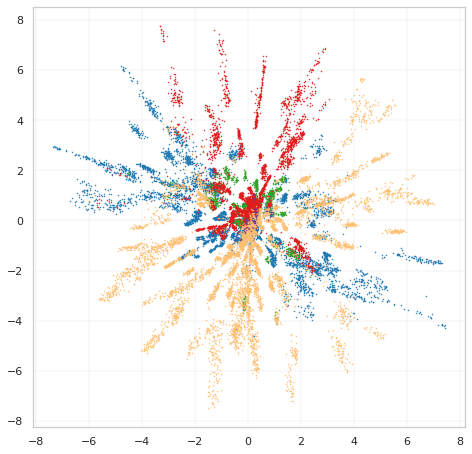

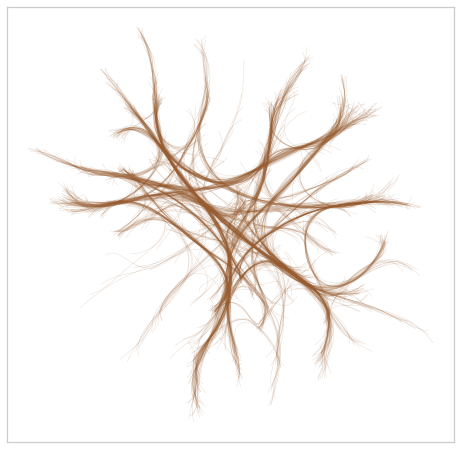

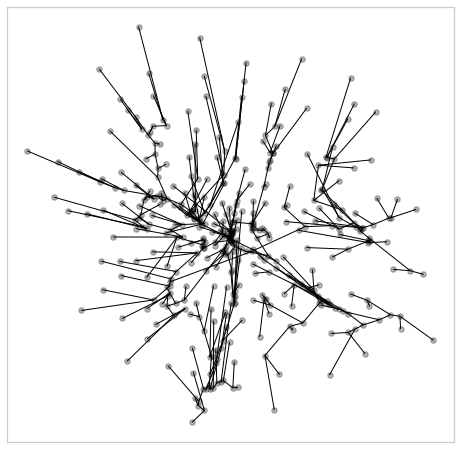

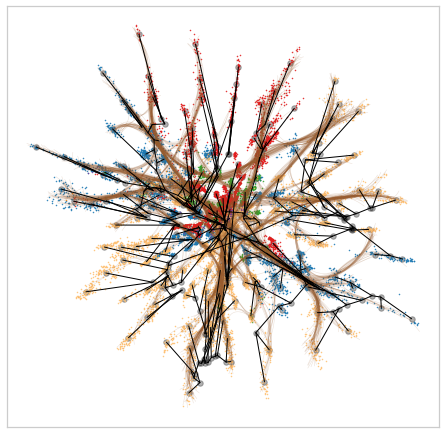

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))

# geodesic color
color_geodesics = "#985C2F"

def plot_embedding_layer():
    plot_embeddings(model, labels, plt.gca(), 
                    precomputed_embeddings=(embeddings['model_PF00144'], idx_mappers['model_PF00144']))
    
def plot_geodesics_layer():
    for points in curve_point_list:
        plt.plot(points[:,0], points[:,1], color=color_geodesics, alpha=0.2, linewidth=0.5)
    
def plot_tree_layer():
    plt.scatter(ancestral_embeddings[:,0], ancestral_embeddings[:,1], color='black', alpha=0.3, s=30)

    ancestral_edges = np.load('ancestral_edges.npy')
    
    for edge in ancestral_edges:
        p1 = ancestral_embeddings[edge[0]]
        p2 = ancestral_embeddings[edge[1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black', linewidth=1.0)
        
        
fig = plt.figure(figsize=(8,8))    
#plt.gca().xaxis.set_ticks([])
#plt.gca().yaxis.set_ticks([])
plot_embedding_layer()    
plt.savefig("geodesic_plot_embedding.svg")

fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_geodesics_layer()
plt.savefig("geodesic_plot_geodesics.svg")
    
fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_tree_layer()
plt.savefig("geodesic_plot_tree.svg")
    

fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_embedding_layer()    
plot_geodesics_layer()
plot_tree_layer()
plt.savefig("geodesic_plot_all.svg")

## Robustness of distances over training instances

In [19]:
# Training 4 additional repetitions of models

# Options
train_models = False

model_repetitions = {'model_PF00144': [dict(models)['model_PF00144']],
                     'model_PF00144_reweighted_0.8': [dict(models)['model_PF00144_reweighted_0.8']]
                    }

#model_repetitions = [[('model_PF00144',dict(models)['model_PF00144'])], 
#                     [('model_PF00144_reweighted_0.8',dict(models)['model_PF00144_reweighted_0.8'])]]
for rep in range(4):

    seed = 123+rep+1
    _, model_pf00144 = train_or_retrieve_model('model_PF00144_r{}'.format(rep), 
                                               data,
                                               weights=None,
                                               epochs=20,
                                               seed=seed,
                                               train_model=train_models,
                                               uncertainty_temperature=-3.5,
                                               mask_out_gaps=True)
    _, model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted_0.8_r{}'.format(rep), 
                                                          data,
                                                          weights=weights['0.8'],
                                                          epochs=20,
                                                          seed=seed,
                                                          train_model=train_models,
                                                          uncertainty_temperature=-3.5,
                                                          mask_out_gaps=True)
    model_repetitions['model_PF00144'].append(model_pf00144)
    model_repetitions['model_PF00144_reweighted_0.8'].append(model_pf00144_reweighted)

Global seed set to 124


Loading from checkpoint!


Global seed set to 124


Loading from checkpoint!


Global seed set to 125


Loading from checkpoint!


Global seed set to 125


Loading from checkpoint!


Global seed set to 126


Loading from checkpoint!


Global seed set to 126


Loading from checkpoint!


Global seed set to 127


Loading from checkpoint!


Global seed set to 127


Loading from checkpoint!


In [20]:
# Calculate embeddings of data set for all repeated training of models
embeddings_rep = {}
for i, model_type in enumerate(model_repetitions):
    print(model_type)
    embeddings_rep[model_type] = []
    for j, model in enumerate(model_repetitions[model_type]):
        print(j)        
        batch_size = 256
        n_batch = int(np.ceil(len(data) / batch_size))
        emb = []
        for b in range(n_batch):
            batch = data[b*batch_size:(b+1)*batch_size]
            emb.append(model.embedding(batch.long().to(model._device)).detach().cpu().numpy())
        embeddings_rep[model_type].append(np.vstack(emb))

        # plot_embeddings(model, labels, ax=ax[i,j], precomputer_embeddings=(embeddings[i][j], idx_mappers[i][j]))
        #embedding, idx_mapper = plot_embeddings(model, labels, ax=ax[i,j])
        #embeddings[-1].append(embedding)
        #idx_mappers[-1].append(idx_mapper)

model_PF00144
0
1
2
3
4
model_PF00144_reweighted_0.8
0
1
2
3
4


0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4


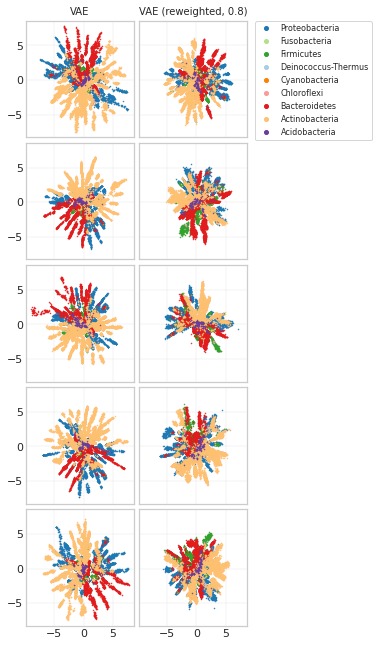

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(6.0, 10), sharex=True, sharey=True)
plt.subplots_adjust(left=0.01, bottom=0, right=0.66, top=0.99, hspace=0.05, wspace=0.05)

for i, model_type in enumerate(model_repetitions):
    #embeddings_rep[model_type] = [].append([])
    for j, model in enumerate(model_repetitions[model_type]):
        print(i,j)
        legend = True if (i,j) == (1,0) else False
        plot_embeddings(model, labels, ax=ax[j,i], precomputed_embeddings=(embeddings_rep[model_type][j], None), legend=False)
        ax[j,i].tick_params(axis='both', which='major', pad=-3)
        if j == 0:
            if i==0:
                ax[j,i].set_title("VAE", fontsize=10)
            if i==1:
                ax[j,i].set_title("VAE (reweighted, 0.8)", fontsize=10)

ax[0,1].legend(markerscale=8, bbox_to_anchor=(1.04,1.035), fontsize=8)
plt.savefig("vae_repetitions.png", dpi=600, bbox_inches='tight')

In [22]:
dms_rep = {}
for i, model_type in enumerate(model_repetitions):
    dms_rep[model_type] = []
    for j, model in enumerate(model_repetitions[model_type]):        
        print('\n Creating discretized manifolds', i, j)
        dms_rep[model_type].append(create_discretized_manifold(model))        


 Creating discretized manifolds 0 0

 Creating discretized manifolds 0 1

 Creating discretized manifolds 0 2

 Creating discretized manifolds 0 3

 Creating discretized manifolds 0 4

 Creating discretized manifolds 1 0

 Creating discretized manifolds 1 1

 Creating discretized manifolds 1 2

 Creating discretized manifolds 1 3

 Creating discretized manifolds 1 4


In [23]:
n_samples = 500

# # Some models are only trained on part of the entire dataset. Therefore, we attempt the lookup, and ignore
# # Failures. We start off with twice as many samples then necessary, and truncate in the end    
# sample_idx = np.random.choice(len(distance_weights), p=distance_weights, size=n_samples)
# sample_idx_i, sample_idx_j = np.unravel_index(sample_idx, df_distance_matrix.values.shape)
# sample_idx = [(i,j) for i,j in zip(sample_idx_i, sample_idx_j)]
# model_idx = sample_idx

sample_idx = sample_idx_rep[0]

# weights = softmax(norms)   
# sample_idx_i = np.random.choice(len(data), size=n_samples, replace=False, p=weights)
# sample_idx_j = np.random.choice(len(data), size=n_samples, replace=False, p=weights)

model_labels = ["", " (reweighted)"]    
    
# Iterate over model types (unweighted, weighted), and repeated training instances
distances_rep = {"vae":[], 
             "vae (reweighted)":[], 
             "vae geo":[], 
             "vae geo (reweighted)":[],              
             "exp hamming": [],
             "exp hamming (reweighted)": []
            }
for idx1, emb_model_type in enumerate(embeddings_rep):
    for idx2, embedding in enumerate(embeddings_rep[emb_model_type]):
                            
        print('\n Calculating VAE distances')
        vae_distances = []
        for i, j in sample_idx:
            em1 = embedding[i]
            em2 = embedding[j]
            vae_distances.append(np.linalg.norm(em1-em2))
        distances_rep["vae{}".format(model_labels[idx1])].append(vae_distances)

        print('\n Calculating VAE geodesics')
        vae_geo_distances = []
        for i, j in sample_idx:
            em1 = embedding[i]
            em2 = embedding[j]
            curve, dist = dms_rep[model_type][idx2].shortest_path(em1, em2)

            if curve.num_nodes >2: 
                curve = numeric_curve_optimizer(model_repetitions[model_type][idx2], curve)
            if i != j and dms_rep[model_type][idx2].grid_point(em1) != dms_rep[model_type][idx2].grid_point(em2):
                curve = SplineApprox(curve)

            dist = float(model_repetitions[model_type][idx2].curve_length(curve(torch.linspace(0, 1, 100))))
            vae_geo_distances.append(dist)
        distances_rep["vae geo{}".format(model_labels[idx1])].append(vae_geo_distances)
        
        print('\n Calculating expected Hamming distances')
        exp_hamming_distances = []
        for i, j in sample_idx:
            em1 = embedding[i]
            em2 = embedding[j]
            dec1 = torch.distributions.Categorical(
                model_repetitions[model_type][idx2].decode(torch.tensor(em1).reshape(1,-1), as_probs=True).permute(0,2,1))
            dec2 = torch.distributions.Categorical(
                model_repetitions[model_type][idx2].decode(torch.tensor(em2).reshape(1,-1), as_probs=True).permute(0,2,1))
            exp_hamming_distances.append(np.mean([scipy.spatial.distance.hamming(
                dec1.sample(), dec2.sample()) for _ in range(20)]))
        distances_rep["exp hamming{}".format(model_labels[idx1])].append(exp_hamming_distances)
        
distances_rep = pd.DataFrame(distances_rep)
distances_rep.to_json("vae_repeated_distance_calculations.json")


 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances


['vae', 'vae (reweighted)', 'vae geo', 'vae geo (reweighted)', 'exp hamming', 'exp hamming (reweighted)']
VAE:  0.32530078
VAE (geodesic):  0.17277253978306648
exp Hamming:  0.02433054290164847


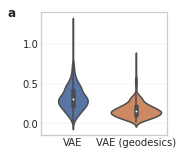

In [24]:
print(list(distances_rep.keys()))
fig = plt.figure(figsize=(2.5,2.1))
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.2, right=None, bottom=0.15, top=0.96)
vae_dist = np.array(distances_rep["vae (reweighted)"].tolist())
vae_dist /= vae_dist.mean(axis=0)
print("VAE: ", np.nanmean(np.std(vae_dist, axis=0)))

vae_geo_dist = np.array(distances_rep["vae geo (reweighted)"].tolist())
vae_geo_dist /= vae_geo_dist.mean(axis=0)
print("VAE (geodesic): ", np.nanmean(np.std(vae_geo_dist, axis=0)))

exp_hamming_dist = np.array(distances_rep["exp hamming (reweighted)"].tolist())
exp_hamming_dist /= exp_hamming_dist.mean(axis=0)
print("exp Hamming: ", np.nanmean(np.std(exp_hamming_dist, axis=0)))

sns.violinplot(
    data=pd.DataFrame({'VAE':np.std(vae_dist, axis=0), 
                       'VAE (geodesics)': np.std(vae_geo_dist, axis=0)}),
                          #'exp hamming': np.std(exp_hamming_dist, axis=0)}))
    )#.set_title('Robustness towards retraining', fontsize=10)
plt.gca().tick_params(axis='x', labelsize=10)
plt.gca().tick_params(axis='y', labelsize=10)

props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)
plt.gcf().text(0.01, 0.91, "a", fontsize=12, weight='bold', 
           verticalalignment='bottom', horizontalalignment='left')
plt.gca().tick_params(axis='both', which='major', pad=-3)

plt.savefig('distance_robustness.pdf')

## 30D VAE latent representation

In [25]:
train_models = False

model_pf00144_z30_name, model_pf00144_z30 = train_or_retrieve_model('model_PF00144_z30', 
                                                                    data,
                                                                    zdim=30,
                                                                    epochs=20,
                                                                    weights=None,
                                                                    train_model=train_models,
                                                                    uncertainty_temperature=-3.5,
                                                                    mask_out_gaps=True)

Global seed set to 123


Loading from checkpoint!


tSNE perplexity:  10.0
tSNE perplexity:  30.0
tSNE perplexity:  100.0


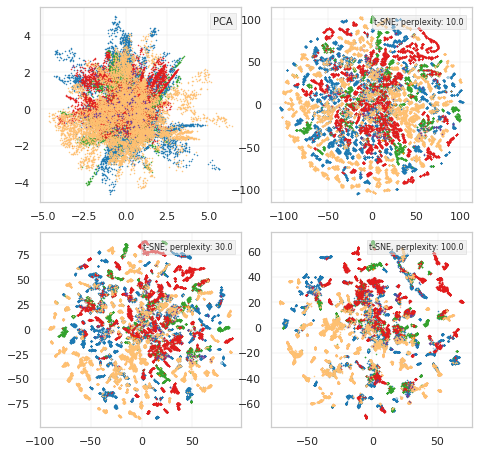

In [26]:
from math import ceil

perplexity_steps = [10., 30., 100.]

figshape = (int(ceil((1+len(perplexity_steps))/2)), 
            int(ceil((1+len(perplexity_steps))/2)))

props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

fig, ax = plt.subplots(figshape[0], figshape[1], figsize=(4*figshape[0], 4*figshape[1]))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.15, wspace=0.15)
    
embeddings_reduced, idx_mapper_reduced = plot_embeddings(model_pf00144_z30, labels, 
                                                         dimensionality_reduction='pca', ax=ax[0,0])
ax[0,0].text(0.96, 0.9, "PCA", transform=ax[0,0].transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=props)

for i, perplexity in enumerate(perplexity_steps):
    fig_i, fig_j = (i+1)//2, (i+1)%2
    print("tSNE perplexity: ", perplexity)
    plot_embeddings(model_pf00144_z30, labels, precomputed_embeddings=(embeddings_reduced, idx_mapper_reduced), 
                    dimensionality_reduction='tsne', tsne_perplexity=perplexity, ax=ax[fig_i, fig_j])

    ax[fig_i, fig_j].text(0.96, 0.9, "t-SNE, perplexity: {}".format(perplexity), transform=ax[fig_i, fig_j].transAxes, fontsize=8,
                          verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.savefig('vae_30d_pca_vs_tsne.png', dpi=600, bbox_inches='tight')

## Variational autoencoder vs standard autoencoder

Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


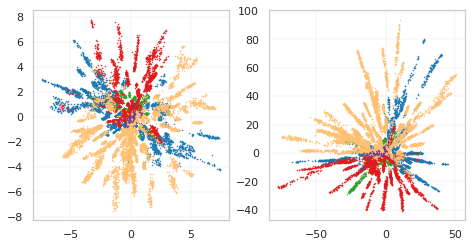

In [29]:
# Options
train_models = False

ae_vs_vae_models = []
ae_vs_vae_models.append(train_or_retrieve_model('model_PF00144', 
                                      data,
                                      weights=None,
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True))
ae_vs_vae_models.append(train_or_retrieve_model('model_PF00144_AE', 
                                      data,
                                      weights=None,
                                      train_model=train_models,
                                      uncertainty_temperature=-3.5,
                                      mask_out_gaps=True,
                                      simplify_to_ae=True,
                                      plot_xlim=None, plot_ylim=None))

fig, ax = plt.subplots(1, len(ae_vs_vae_models), figsize=(len(ae_vs_vae_models)*4, 4))

ae_vs_vae_embeddings = {}
ae_vs_vae_idx_mappers = {}
for idx,(name, model) in enumerate(ae_vs_vae_models):
    embedding, idx_mapper = plot_embeddings(model, labels, ax=ax[idx])
    ae_vs_vae_embeddings[name] = embedding
    ae_vs_vae_idx_mappers[name] = idx_mapper
    
plt.savefig('vae_vs_ae.png', dpi=600, bbox_inches='tight')

## Comparison to large, state-of-the-art transformer language model

In [31]:
try:
    import esm
    from esm import FastaBatchedDataset
except:
    !pip install fair-esm
    import esm
    from esm import FastaBatchedDataset

esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

#esm1b, esm1b_alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")
#esm1b_batch_converter = esm1b_alphabet.get_batch_converter()


In [32]:
# Code adapted from https://github.com/facebookresearch/esm/blob/main/extract.py


def embed_with_esm1b(esm1b, esm1b_alphabet, esm1b_batch_converter, filename, allow_truncation=False):
    
    esm1b_dataset = FastaBatchedDataset.from_file(filename)
    esm1b_batches = esm1b_dataset.get_batch_indices(4096, extra_toks_per_seq=1)
    esm1b_data_loader = torch.utils.data.DataLoader(
        esm1b_dataset, collate_fn=esm1b_alphabet.get_batch_converter(), batch_sampler=esm1b_batches)
    print(f"Read {len(esm1b_dataset)} sequences")

    seq_representations = []
    seq_representation_labels = []
    seq_representation_ids = []
    with torch.no_grad():
        label_re = re.compile(r'\[([^\]]*)\]')
        for batch_idx, (esm1b_ids, strs, toks) in enumerate(esm1b_data_loader):
            print(
                f"Processing {batch_idx + 1} of {len(esm1b_batches)} batches ({toks.size(0)} sequences)"
            )
            if torch.cuda.is_available():
                toks = toks.to(device="cuda", non_blocking=True)

            # The model is trained on truncated sequences and passing longer ones in at
            # inference will cause an error. See https://github.com/facebookresearch/esm/issues/21
            if toks.shape[1] > 1022:
                if allow_truncation:
                    print("WARNING: sequences too long, truncating")
                    toks = toks[:, :1022]
                else:
                    # Skip entire batch
                    continue

            repr_layers = [(i + esm1b.num_layers + 1) % (esm1b.num_layers + 1) for i in [-1]]

            out = esm1b(toks, repr_layers=repr_layers, return_contacts=False)

            representations = list(out["representations"].values())
            assert(len(representations) == 1)
            representations = representations[0]

            representation_dict = {
                    layer: t.to(device="cpu") for layer, t in out["representations"].items()
            }

            for i, id in enumerate(esm1b_ids):
                seq_representations.append(representations[i, 1 : len(strs[i]) + 1].mean(0).clone())
                seq_representation_labels.append(label_re.search(id).group(1))
                seq_representation_ids.append(re.sub(label_re, "", id).rstrip())
                                                
        seq_representations = torch.vstack(seq_representations)

    df = pd.DataFrame({'id': seq_representation_ids,
                      'label': seq_representation_labels,
                      'embedding': seq_representations.cpu().numpy().tolist()})
    return df


run_embedding = False

if run_embedding:

    if torch.cuda.is_available():
        esm1b = esm1b.eval().cuda()

    # Dataset 1: full length sequences
    if not os.path.exists('PF00144_full_length_sequences_labeled.fasta'):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_length_sequences_labeled.fasta

    # Dataset 2: alignment file (same as used above), but with gaps removed
    from Bio.Seq import Seq
    records_gaps_removed = []
    for record in SeqIO.parse("PF00144_full_labeled.fasta", "fasta"):
        record.seq = Seq(str(record.seq).replace('.', '').replace('-',''))
        records_gaps_removed.append(record)
    with open("PF00144_full_labeled_gaps_removed.fasta", "w") as output_file:
        SeqIO.write(records_gaps_removed, output_file, "fasta")

    df_esm1b_full_length = embed_with_esm1b(esm1b, esm1b_alphabet, esm1b_batch_converter, 'PF00144_full_length_sequences_labeled.fasta')
    df_esm1b_full_length_no_truncation = embed_with_esm1b(esm1b, esm1b_alphabet, esm1b_batch_converter, 'PF00144_full_length_sequences_labeled.fasta', allow_truncation=False)
    df_esm1b_gaps_removed = embed_with_esm1b(esm1b, esm1b_alphabet, esm1b_batch_converter, 'PF00144_full_labeled_gaps_removed.fasta')

    import pickle
    with open("esm1b_embeddings_full_seq.pickle", 'wb') as f:
        pickle.dump(df_esm1b_full_length, f)
    with open("esm1b_embeddings_full_seq_no_truncation.pickle", 'wb') as f:
        pickle.dump(df_esm1b_full_length_no_truncation, f)
    with open("esm1b_embeddings_gaps_removed.pickle", 'wb') as f:
        pickle.dump(df_esm1b_gaps_removed, f)

else:
    import pickle
    with open("esm1b_embeddings_full_seq.pickle", 'rb') as f:
        df_esm1b_full_length = pickle.load(f)
    with open("esm1b_embeddings_full_seq_no_truncation.pickle", 'rb') as f:
        df_esm1b_full_length_no_truncation = pickle.load(f)
    with open("esm1b_embeddings_gaps_removed.pickle", 'rb') as f:
        df_esm1b_gaps_removed = pickle.load(f)

In [33]:
n_samples = 500
n_repetitions = 5

#label_re = re.compile(r'\[([^\]]*)\]')
#df_esm1b_gaps_removed['id'] = df_esm1b_gaps_removed['id'].apply(lambda id: re.sub(label_re, "", id).rstrip())
esm1b_embeddings = df_esm1b_gaps_removed.set_index('id')

print(esm1b_embeddings)

distances2 = []
for idx in range(n_repetitions):

#     # Random indices
#     # weight sampling by each points norm to center
#     sample_idx_i = []
#     sample_idx_j = []

# #     # Use same data weighting as in VAE plots
# #     model = dict(models)['model_PF00144']
# #     data_weights = softmax(np.linalg.norm(embeddings['model_PF00144'], ord=2, axis=-1))
    
# #     sample_idx_i = np.random.choice(len(model.train_dataloader().dataset), size=n_samples, replace=False, p=data_weights)
# #     sample_idx_j = np.random.choice(len(model.train_dataloader().dataset), size=n_samples, replace=False, p=data_weights)    

#     sample_idx_i = np.random.choice(len(model.train_dataloader().dataset), size=n_samples, replace=False)
#     sample_idx_j = np.random.choice(len(model.train_dataloader().dataset), size=n_samples, replace=False)    

    sample_idx = sample_idx_rep[idx]
    
    print('\t Calculating phylogenetic distances')
    #embedded_ids = np.array(ids)[idx_mappers[model_name]]    
    phylo_distances = []
    for i, j in sample_idx:
        phylo_distances.append(td.id_to_id_dist(ids[i], 
                                                ids[j]))

    print('\t Calculating ESM1b distances')
    esm1b_distances = []
    for i, j in sample_idx:
        # em1 = np.array(esm1b_embeddings.loc[embedded_ids[i], 'embedding'])
        # em2 = np.array(esm1b_embeddings.loc[embedded_ids[j], 'embedding'])
        em1 = np.array(esm1b_embeddings.loc[ids[i], 'embedding'])
        em2 = np.array(esm1b_embeddings.loc[ids[j], 'embedding'])
        esm1b_distances.append(np.linalg.norm(em1-em2))

        
    distances2.append(np.vstack([np.array(esm1b_distances), np.array(phylo_distances)]))
    
scatter_datapoints = np.stack(distances2)    


                                  label  \
id                                        
A0A0A1CZQ5_9MICC/2-38    Actinobacteria   
A0A1C5F484_9ACTN/2-39    Actinobacteria   
F3MSY2_LACRH/1-41            Firmicutes   
A0A0B8PPZ8_9VIBR/1-43    Proteobacteria   
K4ZRC4_PAEAL/49-91           Firmicutes   
...                                 ...   
X0Q6I6_9GAMM/20-471      Proteobacteria   
U4T1U9_9GAMM/16-468      Proteobacteria   
Q4FS52_PSYA2/22-482      Proteobacteria   
A0A1U6GN70_9GAMM/21-482  Proteobacteria   
A0A098G5W5_9GAMM/8-479   Proteobacteria   

                                                                 embedding  
id                                                                          
A0A0A1CZQ5_9MICC/2-38    [0.22001589834690094, -0.02485605515539646, 0....  
A0A1C5F484_9ACTN/2-39    [0.2980002760887146, 0.17585569620132446, 0.03...  
F3MSY2_LACRH/1-41        [0.07145749032497406, 0.06638508290052414, -0....  
A0A0B8PPZ8_9VIBR/1-43    [0.09700572490692139, 0.212892

(34241, 1280)
(28393, 1280)


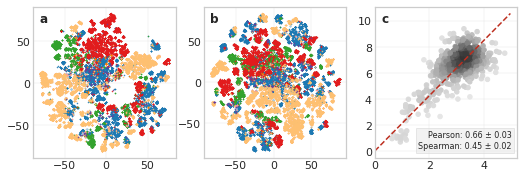

In [34]:

fig, ax = plt.subplots(1, 3, figsize=(8.0, 2.5))
plt.subplots_adjust(left=0.01, bottom=0, right=0.99, top=0.99)
#for idx, df in enumerate([df_esm1b_full_length, df_esm1b_full_length_no_truncation, df_esm1b_gaps_removed]):
for idx, df in enumerate([df_esm1b_full_length, df_esm1b_gaps_removed]):
    esm1b_embeddings = np.array(df['embedding'].values.tolist())
    print(esm1b_embeddings.shape)
    idx_mapper = torch.arange(esm1b_embeddings.shape[0])

    plot_embeddings(None, df['label'], ax=ax[idx], precomputed_embeddings=(esm1b_embeddings, None), legend=False,
                   dimensionality_reduction="tsne", tsne_perplexity=30.)
    ax[idx].tick_params(axis='both', which='major', pad=-3)

    ax[idx].text(0.1, 0.875, "ab"[idx], fontsize=12, weight='bold', 
           verticalalignment='bottom', horizontalalignment='right', transform=ax[idx].transAxes)

scatter_plot(scatter_datapoints, ax[-1])
ax[2].text(0.1, 0.875, "c", fontsize=12, weight='bold', 
       verticalalignment='bottom', horizontalalignment='right', transform=ax[2].transAxes)


plt.savefig('esm1b_embeddings.png', dpi=600, bbox_inches='tight')